# loading libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import pathlib
import pandas as pd
import numpy as np
import darts
from darts import TimeSeries
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import os
import glob
from tqdm import tqdm
from darts.dataprocessing.transformers.scaler import Scaler

# Helping Functions


In [2]:
import numpy as np


def calculate_metrics(actual, predicted):
    # Convert inputs to numpy arrays for easier calculations
    actual = np.array(actual)
    predicted = np.array(predicted)

    # Calculate individual metrics
    mae = np.mean(np.abs(predicted - actual))
    rmse = np.sqrt(np.mean((predicted - actual) ** 2))
    mape = np.mean(np.abs((predicted - actual) / actual)) * 100
    mse = np.mean((predicted - actual) ** 2)

    metrics = {"MAE": mae, "RMSE": rmse, "MAPE": mape, "MSE": mse}

    return metrics

# Data Reading 😶

In [3]:
fileName = "highcorrelated_features"
df = pd.read_csv(f"../ProcessedData/{fileName}/{fileName}.csv")
df.head()

,date,net_sales_total,net_order_entry_total,mitarbeiter_vertrieb,mitarbeiter_service,mitarbeiter_total
0,2014-01-31,9914.85,13197.85,94,178,272
1,2014-02-28,8793.66,11632.08,96,178,274
2,2014-03-31,12689.12,14404.37,97,179,276
3,2014-04-30,12420.60,11512.26,97,180,277
4,2014-05-31,11825.02,11875.16,99,178,277


In [4]:
df = df[["date", "net_sales_total"]]
df = df.drop_duplicates()
df.head()

,date,net_sales_total
0,2014-01-31,9914.85
1,2014-02-28,8793.66
2,2014-03-31,12689.12
3,2014-04-30,12420.60
4,2014-05-31,11825.02


# stationary Tesst

In [5]:
def adfuller_test(values):
    result = adfuller(values)
    labels = [
        "ADF Test Statistic",
        "p-value",
        "#Lags Used",
        "Number of Observations Used",
    ]
    for value, label in zip(result, labels):
        print(label + " : " + str(value))
    if result[1] <= 0.05:
        print(
            "P value is less than 0.05 that means we can reject the null hypothesis(Ho). Therefore we can conclude that data has no unit root and is stationary"
        )
    else:
        print(
            "Weak evidence against null hypothesis that means time series has a unit root which indicates that it is non-stationary "
        )

In [6]:
adfuller_test(df["net_sales_total"])

ADF Test Statistic : -0.5945418906256462
p-value : 0.8722105724767181
#Lags Used : 13
Number of Observations Used : 94
Weak evidence against null hypothesis that means time series has a unit root which indicates that it is non-stationary 


In [7]:
adfuller_test(df["net_sales_total"].diff(1).iloc[1:])

ADF Test Statistic : -4.015772404893064
p-value : 0.0013301372561128658
#Lags Used : 12
Number of Observations Used : 94
P value is less than 0.05 that means we can reject the null hypothesis(Ho). Therefore we can conclude that data has no unit root and is stationary


## Spliting Data into Training & Testing Data

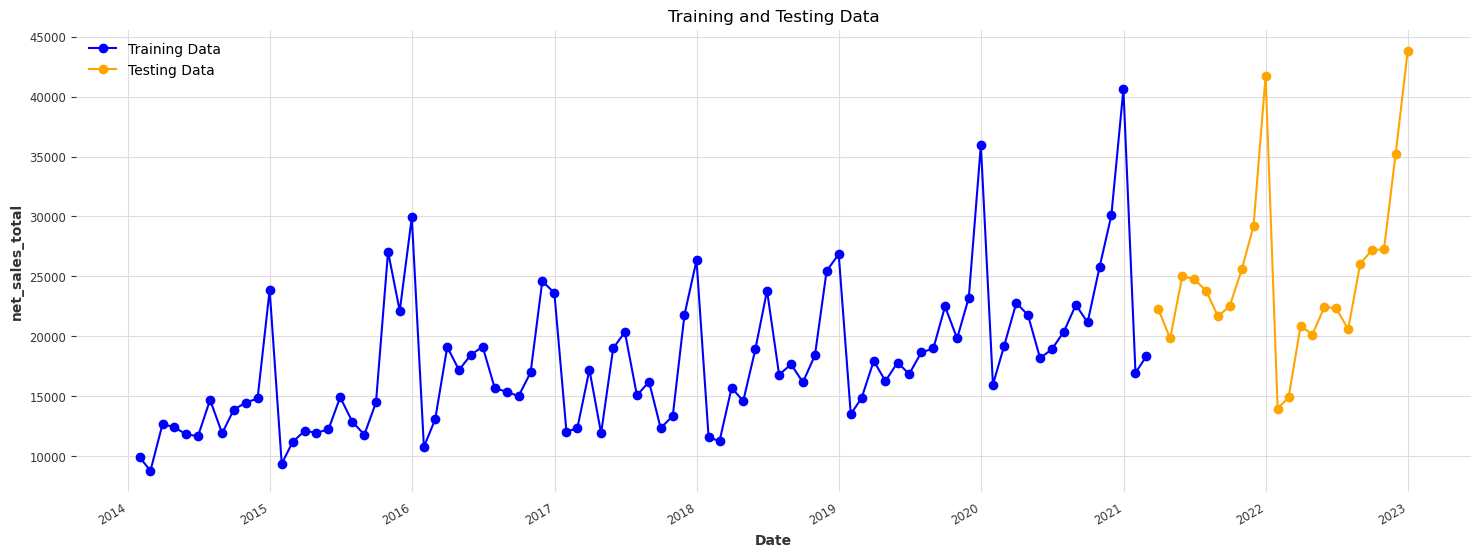

In [8]:
from darts import TimeSeries
import numpy as np
import matplotlib.pyplot as plt

# Assuming df is your DataFrame containing daily data
series = TimeSeries.from_dataframe(
    df, "date", "net_sales_total", freq="1M", fill_missing_dates=True, fillna_value=0
)


split_point = 0.80

train_series, test_series = series.split_after(split_point)

# Set the figure size and style
plt.figure(figsize=(18, 6))
# Plot the training and testing data
train_series.plot(label="Training Data", color="blue", linewidth=1.5, marker="o")
test_series.plot(label="Testing Data", color="orange", linewidth=1.5, marker="o")

# Add title and labels
plt.title("Training and Testing Data")
plt.xlabel("Date")
plt.ylabel("net_sales_total")

# Add grid lines
plt.grid(True)

# Add legend
plt.legend()

# Display the plot
plt.show()

# XGB Model

Specified future encoders in `add_encoders` at model creation but model does not accept future covariates. future encoders will be ignored.


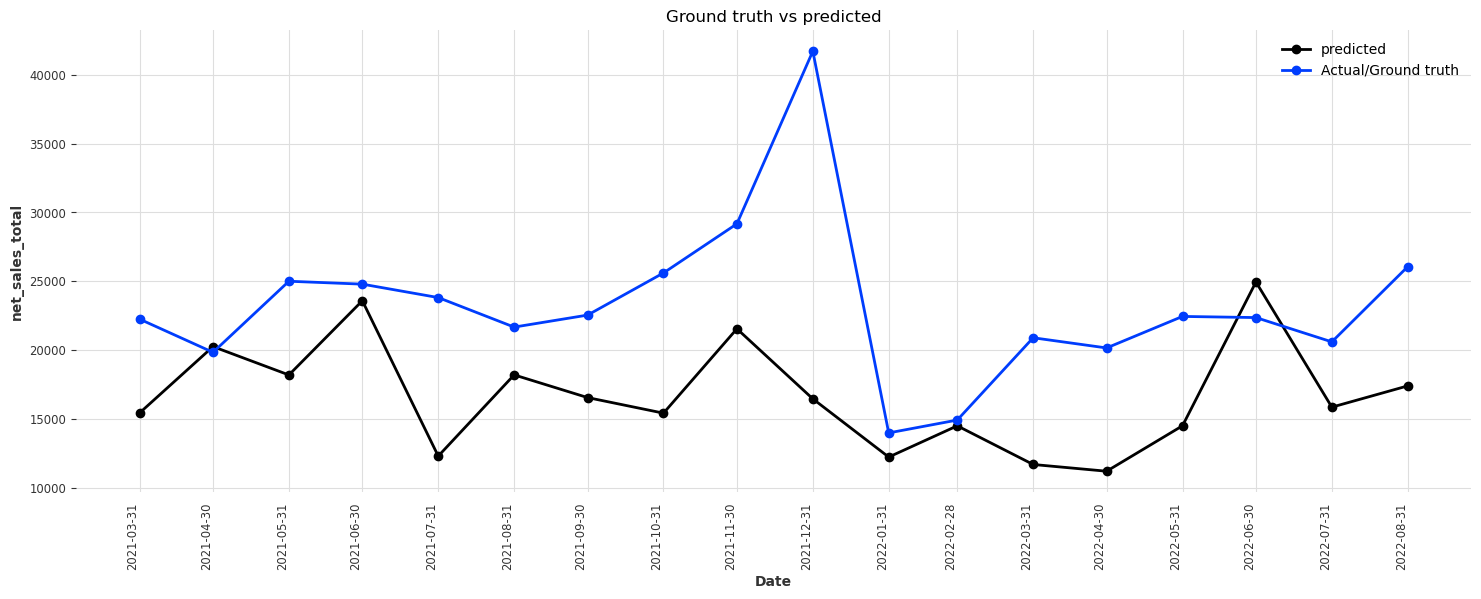

In [21]:
from darts.models.forecasting.xgboost import XGBModel

xgb_model = XGBModel(
    lags=6,
    output_chunk_length=30,
    add_encoders={
        "cyclic": {"future": ["month"]},
        "datetime_attribute": {"future": ["hour", "dayofweek"]},
        "position": {"future": ["relative"]},
        "custom": {"future": [lambda idx: (idx.year - 2013) / 50]},
        "transformer": Scaler(),
    },
    likelihood=None,
    quantiles=False,
    random_state=199,
    multi_models=True,
    use_static_covariates=True,
)

xgb_model.fit(train_series)

horizan = 18
test_series_ = test_series[0:horizan]
plt.figure(figsize=(18, 6))

forcast_arima = xgb_model.predict(horizan)
xgb_model.predict(horizan).plot(marker="o", label="predicted")
test_series_.plot(marker="o", label="Actual/Ground truth")
# Add title and labels
plt.title("Ground truth vs predicted")
plt.xlabel("Date")
plt.ylabel("net_sales_total")
plt.xticks(
    forcast_arima.time_index, forcast_arima.time_index.strftime("%Y-%m-%d"), rotation=90
)

# Add grid lines
plt.grid(True)

# Add legend
plt.legend()

# Display the plot
plt.show()

In [23]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm


# Function to predict and evaluate
def predict_and_evaluate(
    window_size,
    prediction_horizon,
    slide_step,
    test_series,
    arima_model,
    result_plot_path,
):
    num_predictions = len(test_series) - window_size - prediction_horizon + 1

    meta_information_evaluation = {
        "Iterations": [],
        "MAE": [],
        "RMSE": [],
        "MAPE": [],
        "MSE": [],
        "input_window_size": [],
        "horizon": [],
        "stride": [],
    }

    try:
        for i in tqdm(range(0, num_predictions, slide_step)):
            input_window = test_series[i : i + window_size]
            ground_truth = test_series[
                i + window_size : i + window_size + prediction_horizon
            ]
            forecast = arima_model.predict(n=prediction_horizon, series=input_window)

            actual = ground_truth.values().flatten().tolist()
            predicted = forecast.values().flatten().tolist()

            metrics = calculate_metrics(actual, predicted)

            meta_information_evaluation["Iterations"].append(i)
            meta_information_evaluation["MAE"].append(metrics["MAE"])
            meta_information_evaluation["RMSE"].append(metrics["RMSE"])
            meta_information_evaluation["MAPE"].append(metrics["MAPE"])
            meta_information_evaluation["MSE"].append(metrics["MSE"])
            meta_information_evaluation["input_window_size"].append(window_size)
            meta_information_evaluation["horizon"].append(prediction_horizon)
            meta_information_evaluation["stride"].append(slide_step)

            bypass_information = {
                "slide_step": slide_step,
                "window_size": window_size,
                "horizon": prediction_horizon,
            }
            create_plots(
                input_window,
                forecast,
                ground_truth,
                result_plot_path,
                bypass_information,
            )

        evalaution_df = pd.DataFrame.from_dict(meta_information_evaluation)

        return evalaution_df

    except Exception as e:
        print("Error Occurred in fuction predict_and_evaluate():", e)
        evalaution_df = pd.DataFrame.from_dict(meta_information_evaluation)

        return evalaution_df


# Function to create plots
def create_plots(
    input_window, forecast, ground_truth, result_plot_path, bypass_information
):
    plt.figure(figsize=(30, 6))
    input_window.plot(label="Input Data", marker="o")
    forecast.plot(label="Predicted", marker="o")
    ground_truth.plot(label="Ground Truth", marker="o")

    combined_time_index = input_window.time_index.append(forecast.time_index).append(
        ground_truth.time_index
    )
    starting_date_of_input_data = input_window.time_index[0].strftime("%Y-%m-%d")
    ending_date_of_input_data = input_window.time_index[-1].strftime("%Y-%m-%d")
    starting_date_predicted = forecast.time_index[0].strftime("%Y-%m-%d")
    ending_date_of_predicted = forecast.time_index[-1].strftime("%Y-%m-%d")

    plt.xticks(
        combined_time_index, combined_time_index.strftime("%Y-%m-%d"), rotation=90
    )
    plt.title(
        f"Results of Input Data from {starting_date_of_input_data} to {ending_date_of_input_data} & Evaluation on from {starting_date_predicted} to {ending_date_of_predicted}",
        fontsize=16,
    )
    plt.ylabel("net_sales_total", fontsize=14)
    plt.xlabel("Dates", fontsize=14)
    plt.legend()

    plot_filename = f"{result_plot_path}/{bypass_information['window_size']}_{bypass_information['horizon']}_{bypass_information['slide_step']}.png"
    plt.savefig(plot_filename)
    plt.close()
    # plt.show()

# Model Evaluation

In [24]:
def model_evaluation(model_name, model_object, test_series, FileName):
    result_path = f"../ProcessedData/Results/{model_name}/{FileName}"
    result_plot_path = (
        f"../ProcessedData/Results/{model_name}/{FileName}/{model_name}_Plots"
    )
    os.makedirs(result_path, exist_ok=True)
    os.makedirs(result_plot_path, exist_ok=True)

    # Set your parameters
    window_sizes = [6, 12, 18]
    prediction_horizons = [6, 12, 18]
    slide_steps = [2, 5, 8]

    test_series = test_series
    model = model_object

    for window_size in window_sizes:
        for prediction_horizon in prediction_horizons:
            for slide_step in slide_steps:
                print(
                    f"Iteration : Window size : {window_size} Horizan: {prediction_horizon}, Stride : {slide_step}"
                )
                evaluation_df = predict_and_evaluate(
                    window_size,
                    prediction_horizon,
                    slide_step,
                    test_series,
                    model,
                    result_plot_path,
                )
                evaluation_df.to_csv(
                    f"{result_path}/window_size_{window_size}_horizon_{prediction_horizon}_stride_{slide_step}.csv",
                    index=False,
                )

                print(
                    f"Window_size_{window_size}_prediction_horizon_{prediction_horizon}_slide_step_{slide_step} - Evaluation completed."
                )
        #         break
        #     break
        # break

## XGBModel

In [25]:
model_name = "XGBMODEl"
model_object = xgb_model
FileName = fileName
test_series = test_series
model_evaluation(model_name, model_object, test_series, FileName)

Iteration : Window size : 6 Horizan: 6, Stride : 2


100%|██████████| 6/6 [00:02<00:00,  2.71it/s]


Window_size_6_prediction_horizon_6_slide_step_2 - Evaluation completed.
Iteration : Window size : 6 Horizan: 6, Stride : 5


100%|██████████| 3/3 [00:01<00:00,  2.51it/s]


Window_size_6_prediction_horizon_6_slide_step_5 - Evaluation completed.
Iteration : Window size : 6 Horizan: 6, Stride : 8


100%|██████████| 2/2 [00:00<00:00,  2.60it/s]


Window_size_6_prediction_horizon_6_slide_step_8 - Evaluation completed.
Iteration : Window size : 6 Horizan: 12, Stride : 2


100%|██████████| 3/3 [00:01<00:00,  2.10it/s]


Window_size_6_prediction_horizon_12_slide_step_2 - Evaluation completed.
Iteration : Window size : 6 Horizan: 12, Stride : 5


100%|██████████| 1/1 [00:00<00:00,  2.05it/s]


Window_size_6_prediction_horizon_12_slide_step_5 - Evaluation completed.
Iteration : Window size : 6 Horizan: 12, Stride : 8


100%|██████████| 1/1 [00:00<00:00,  2.17it/s]


Window_size_6_prediction_horizon_12_slide_step_8 - Evaluation completed.
Iteration : Window size : 6 Horizan: 18, Stride : 2


0it [00:00, ?it/s]


Window_size_6_prediction_horizon_18_slide_step_2 - Evaluation completed.
Iteration : Window size : 6 Horizan: 18, Stride : 5


0it [00:00, ?it/s]


Window_size_6_prediction_horizon_18_slide_step_5 - Evaluation completed.
Iteration : Window size : 6 Horizan: 18, Stride : 8


0it [00:00, ?it/s]


Window_size_6_prediction_horizon_18_slide_step_8 - Evaluation completed.
Iteration : Window size : 12 Horizan: 6, Stride : 2


100%|██████████| 3/3 [00:01<00:00,  2.31it/s]


Window_size_12_prediction_horizon_6_slide_step_2 - Evaluation completed.
Iteration : Window size : 12 Horizan: 6, Stride : 5


100%|██████████| 1/1 [00:00<00:00,  2.33it/s]


Window_size_12_prediction_horizon_6_slide_step_5 - Evaluation completed.
Iteration : Window size : 12 Horizan: 6, Stride : 8


100%|██████████| 1/1 [00:00<00:00,  2.49it/s]


Window_size_12_prediction_horizon_6_slide_step_8 - Evaluation completed.
Iteration : Window size : 12 Horizan: 12, Stride : 2


0it [00:00, ?it/s]


Window_size_12_prediction_horizon_12_slide_step_2 - Evaluation completed.
Iteration : Window size : 12 Horizan: 12, Stride : 5


0it [00:00, ?it/s]


Window_size_12_prediction_horizon_12_slide_step_5 - Evaluation completed.
Iteration : Window size : 12 Horizan: 12, Stride : 8


0it [00:00, ?it/s]


Window_size_12_prediction_horizon_12_slide_step_8 - Evaluation completed.
Iteration : Window size : 12 Horizan: 18, Stride : 2


0it [00:00, ?it/s]


Window_size_12_prediction_horizon_18_slide_step_2 - Evaluation completed.
Iteration : Window size : 12 Horizan: 18, Stride : 5


0it [00:00, ?it/s]


Window_size_12_prediction_horizon_18_slide_step_5 - Evaluation completed.
Iteration : Window size : 12 Horizan: 18, Stride : 8


0it [00:00, ?it/s]


Window_size_12_prediction_horizon_18_slide_step_8 - Evaluation completed.
Iteration : Window size : 18 Horizan: 6, Stride : 2


0it [00:00, ?it/s]


Window_size_18_prediction_horizon_6_slide_step_2 - Evaluation completed.
Iteration : Window size : 18 Horizan: 6, Stride : 5


0it [00:00, ?it/s]


Window_size_18_prediction_horizon_6_slide_step_5 - Evaluation completed.
Iteration : Window size : 18 Horizan: 6, Stride : 8


0it [00:00, ?it/s]


Window_size_18_prediction_horizon_6_slide_step_8 - Evaluation completed.
Iteration : Window size : 18 Horizan: 12, Stride : 2


0it [00:00, ?it/s]


Window_size_18_prediction_horizon_12_slide_step_2 - Evaluation completed.
Iteration : Window size : 18 Horizan: 12, Stride : 5


0it [00:00, ?it/s]


Window_size_18_prediction_horizon_12_slide_step_5 - Evaluation completed.
Iteration : Window size : 18 Horizan: 12, Stride : 8


0it [00:00, ?it/s]


Window_size_18_prediction_horizon_12_slide_step_8 - Evaluation completed.
Iteration : Window size : 18 Horizan: 18, Stride : 2


0it [00:00, ?it/s]


Window_size_18_prediction_horizon_18_slide_step_2 - Evaluation completed.
Iteration : Window size : 18 Horizan: 18, Stride : 5


0it [00:00, ?it/s]


Window_size_18_prediction_horizon_18_slide_step_5 - Evaluation completed.
Iteration : Window size : 18 Horizan: 18, Stride : 8


0it [00:00, ?it/s]

Window_size_18_prediction_horizon_18_slide_step_8 - Evaluation completed.


# Evaluate Metrics

In [26]:
import pandas as pd
import glob


def aggregate_evaluation_results(file_pattern):
    eval_dict = {
        "window_size": [],
        "horizan": [],
        "stride": [],
        "AVG_MAE": [],
        "AVG_MSE": [],
        "AVG_RMSE": [],
        "AVG_MAPE": [],
    }

    paths = glob.glob(file_pattern)

    for path in paths:
        window_size = path.split("/")[-1].split("_")[2]
        horizan = path.split("/")[-1].split("_")[4]
        stride = path.split("/")[-1].split("_")[6].split(".")[0]

        df = pd.read_csv(path)
        eval_dict["window_size"].append(window_size)
        eval_dict["horizan"].append(horizan)
        eval_dict["stride"].append(stride)

        eval_dict["AVG_MAE"].append(df["MAE"].mean())
        eval_dict["AVG_MSE"].append(df["MSE"].mean())
        eval_dict["AVG_RMSE"].append(df["RMSE"].mean())
        eval_dict["AVG_MAPE"].append(df["MAPE"].mean())

    eval_df = pd.DataFrame.from_dict(eval_dict)
    eval_df = eval_df.dropna()
    eval_df.sort_values(
        ["window_size", "horizan", "stride"], inplace=True, ascending=True
    )

    return eval_df


# Example usage
file_pattern = f"../ProcessedData/Results/XGBMODEl/{fileName}/*.csv"
result_df = aggregate_evaluation_results(file_pattern)
# result_df.to_csv('../ProcessedData/FinalResults/') # have to add folder for each model
result_df

,window_size,horizan,stride,AVG_MAE,AVG_MSE,AVG_RMSE,AVG_MAPE
23,12,6,2,8017.053088,9.460755e+07,9245.144667,29.450823
13,12,6,5,4936.804753,3.921743e+07,6262.382406,21.496901
0,12,6,8,4936.804753,3.921743e+07,6262.382406,21.496901
19,6,12,2,7068.089058,8.930277e+07,9410.868805,26.613009
9,6,12,5,6767.775013,7.028889e+07,8383.847159,27.134308
22,6,12,8,6767.775013,7.028889e+07,8383.847159,27.134308
17,6,6,2,7806.366788,1.003931e+08,9306.172466,29.729597
16,6,6,5,8416.995718,1.069833e+08,9553.111960,31.274775
5,6,6,8,8795.448652,9.516734e+07,9631.967413,34.521409


In [28]:
result_df

,window_size,horizan,stride,AVG_MAE,AVG_MSE,AVG_RMSE,AVG_MAPE
23,12,6,2,8017.053088,9.460755e+07,9245.144667,29.450823
13,12,6,5,4936.804753,3.921743e+07,6262.382406,21.496901
0,12,6,8,4936.804753,3.921743e+07,6262.382406,21.496901
19,6,12,2,7068.089058,8.930277e+07,9410.868805,26.613009
9,6,12,5,6767.775013,7.028889e+07,8383.847159,27.134308
22,6,12,8,6767.775013,7.028889e+07,8383.847159,27.134308
17,6,6,2,7806.366788,1.003931e+08,9306.172466,29.729597
16,6,6,5,8416.995718,1.069833e+08,9553.111960,31.274775
5,6,6,8,8795.448652,9.516734e+07,9631.967413,34.521409


In [27]:

for name, group in result_df.groupby(["window_size", "horizan"]):
    print(name)
    display(group)

('12', '6')


,window_size,horizan,stride,AVG_MAE,AVG_MSE,AVG_RMSE,AVG_MAPE
23,12,6,2,8017.053088,9.460755e+07,9245.144667,29.450823
13,12,6,5,4936.804753,3.921743e+07,6262.382406,21.496901
0,12,6,8,4936.804753,3.921743e+07,6262.382406,21.496901


('6', '12')


,window_size,horizan,stride,AVG_MAE,AVG_MSE,AVG_RMSE,AVG_MAPE
19,6,12,2,7068.089058,8.930277e+07,9410.868805,26.613009
9,6,12,5,6767.775013,7.028889e+07,8383.847159,27.134308
22,6,12,8,6767.775013,7.028889e+07,8383.847159,27.134308


('6', '6')


,window_size,horizan,stride,AVG_MAE,AVG_MSE,AVG_RMSE,AVG_MAPE
17,6,6,2,7806.366788,1.003931e+08,9306.172466,29.729597
16,6,6,5,8416.995718,1.069833e+08,9553.111960,31.274775
5,6,6,8,8795.448652,9.516734e+07,9631.967413,34.521409
